<a href="https://colab.research.google.com/github/krishn305/first-to/blob/main/Dva_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import shap
import joblib


Understanding the Data

In [ ]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df.shape

(5110, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [ ]:
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [ ]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


<Axes: xlabel='stroke', ylabel='count'>

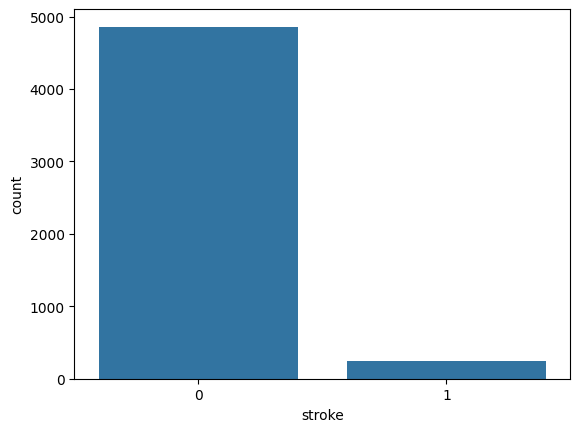

In [ ]:
df['stroke'].value_counts(normalize=True)
sns.countplot(x='stroke', data=df)

Data Balancing

In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop('stroke', axis=1)
y = df['stroke']

X = pd.get_dummies(X, drop_first=True)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [ ]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

Encoding and Standardisation

In [ ]:
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [ ]:
df.drop(['id'], axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()
df[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(df[['age', 'avg_glucose_level', 'bmi']])

In [ ]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')

In [ ]:
df.dtypes


,0
age,float64
hypertension,int64
heart_disease,int64
avg_glucose_level,float64
bmi,float64
stroke,int64
gender_Male,bool
gender_Other,bool
ever_married_Yes,bool
work_type_Never_worked,bool


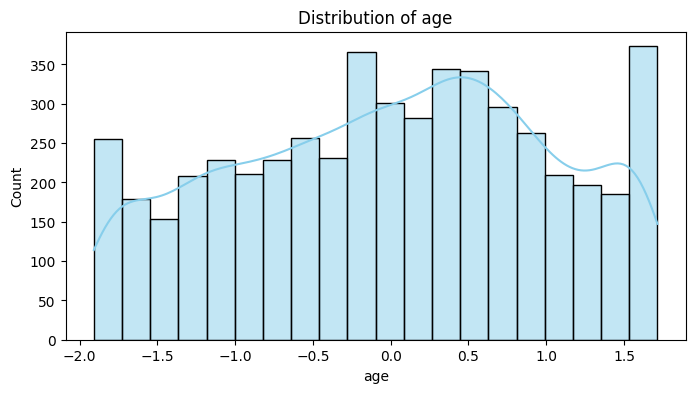

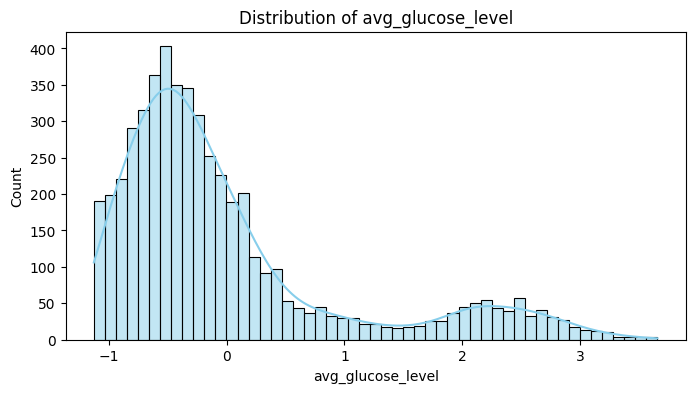

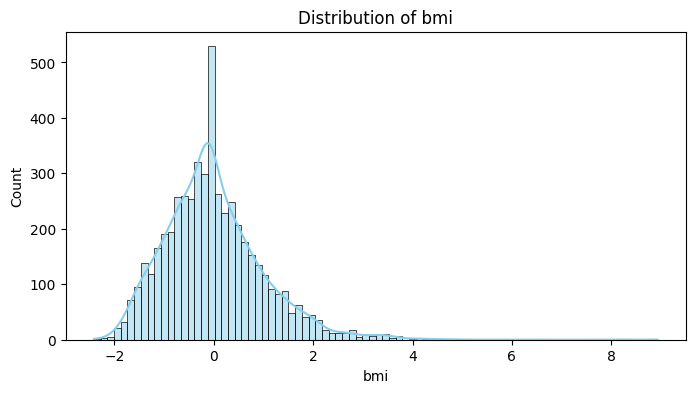

In [ ]:
num_cols = ['age', 'avg_glucose_level', 'bmi']

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.show()


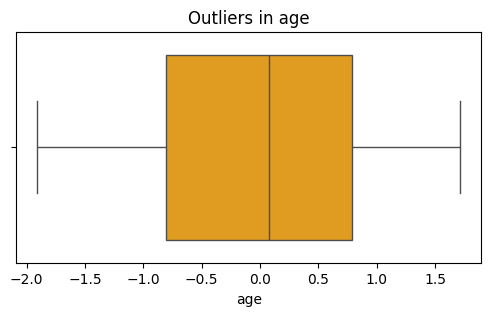

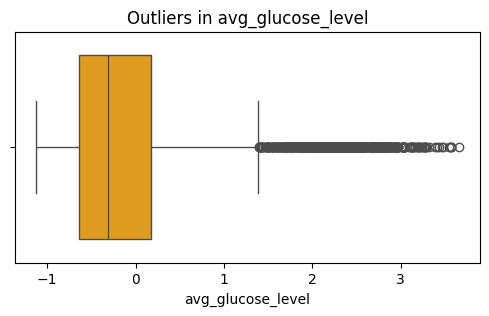

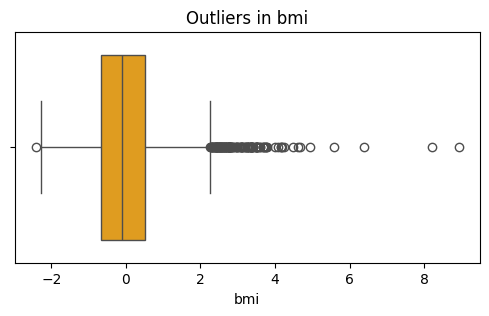

In [ ]:
# boxoutliers
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col], color='orange')
    plt.title(f"Outliers in {col}")
    plt.show()


/tmp/ipython-input-3626658988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette='coolwarm')


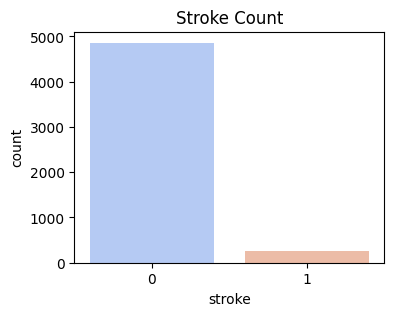

stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


In [ ]:
#Target Variable (Stroke)
plt.figure(figsize=(4,3))
sns.countplot(x='stroke', data=df, palette='coolwarm')
plt.title("Stroke Count")
plt.show()

stroke_rate = df['stroke'].value_counts(normalize=True) * 100
print(stroke_rate)


/tmp/ipython-input-3185012576.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stroke', y=col, data=df, palette='pastel')


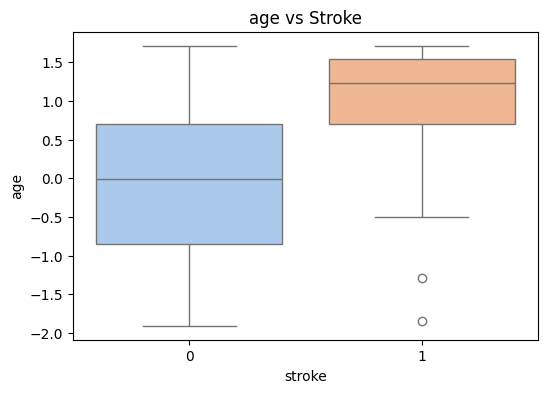

/tmp/ipython-input-3185012576.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stroke', y=col, data=df, palette='pastel')


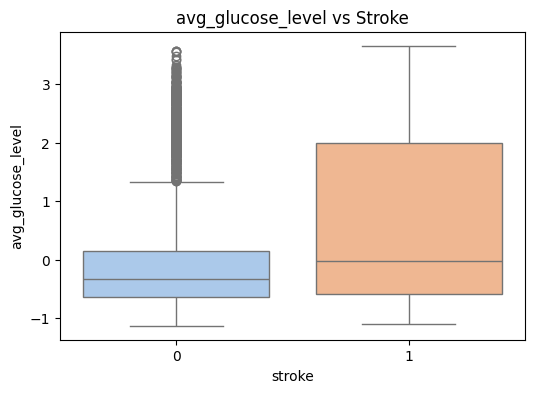

/tmp/ipython-input-3185012576.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stroke', y=col, data=df, palette='pastel')


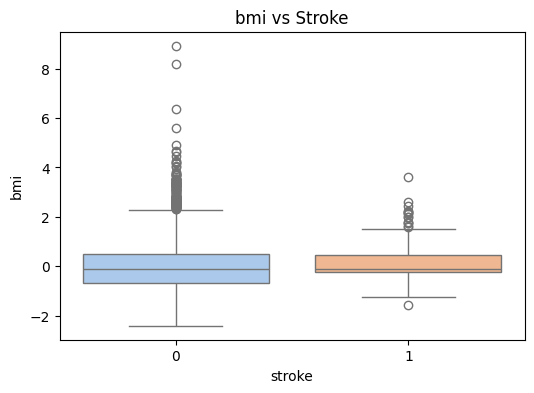

In [ ]:
#Bivariate Analysis (2 Variables)
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='stroke', y=col, data=df, palette='pastel')
    plt.title(f"{col} vs Stroke")
    plt.show()


In [ ]:
#Mean comparision
df.groupby('stroke')[num_cols].mean()


,age,avg_glucose_level,bmi
stroke,,,
0,-0.055508,-0.029863,-0.008173
1,1.083640,0.582985,0.159548


from matplotlib import pyplot as plt
_df_0['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['avg_glucose_level'].plot(kind='hist', bins=20, title='avg_glucose_level')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['bmi'].plot(kind='hist', bins=20, title='bmi')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='age', y='avg_glucose_level', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='avg_glucose_level', y='bmi', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['age']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'age'}, axis=1)
              .sort_values('age', ascending=True))
  xs = counted['age']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('age', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('age')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['avg_glucose_level']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'avg_glucose_level'}, axis=1)
              .sort_values('avg_glucose_level', ascending=True))
  xs = counted['avg_glucose_level']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('avg_glucose_level', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('avg_glucose_level')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['bmi']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'bmi'}, axis=1)
              .sort_values('bmi', ascending=True))
  xs = counted['bmi']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('bmi', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('bmi')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['avg_glucose_level'].plot(kind='line', figsize=(8, 4), title='avg_glucose_level')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['bmi'].plot(kind='line', figsize=(8, 4), title='bmi')
plt.gca().spines[['top', 'right']].set_visible(False)

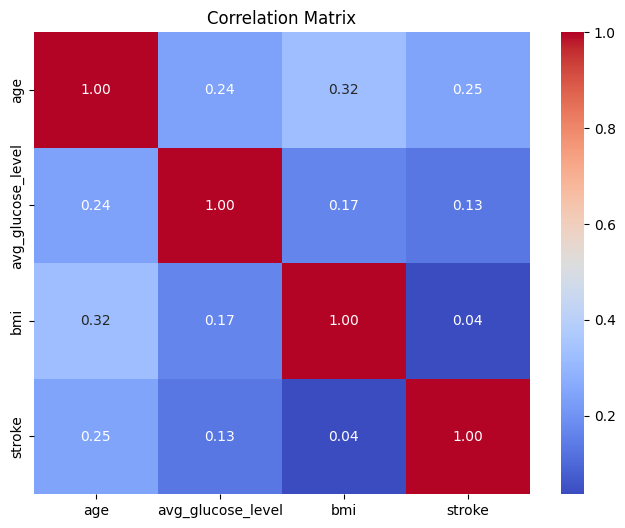

In [ ]:
#Multivariant
corr = df[num_cols + ['stroke']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


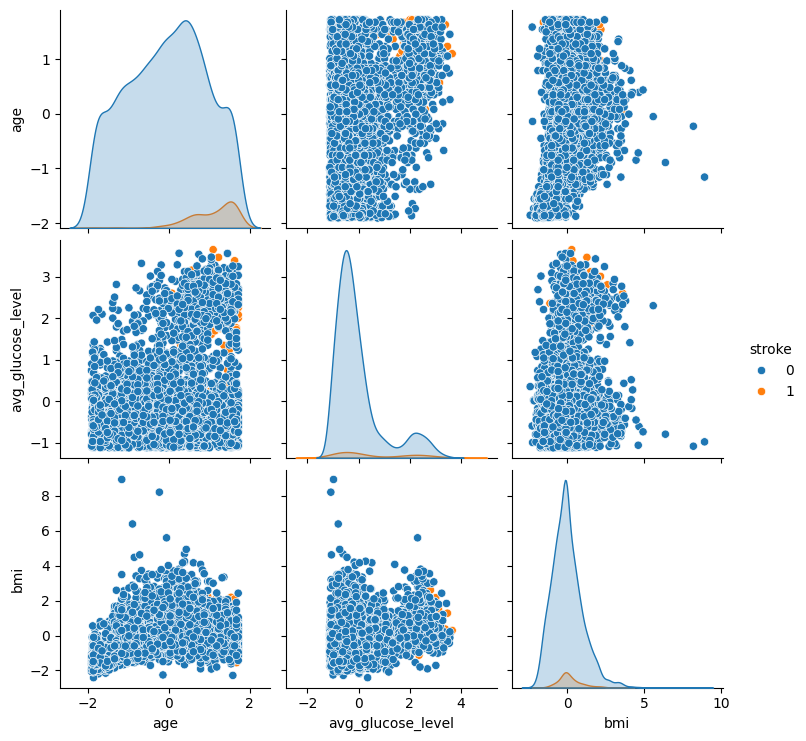

In [ ]:
#Pairplot
sns.pairplot(df, vars=['age', 'avg_glucose_level', 'bmi'], hue='stroke', diag_kind='kde')
plt.show()


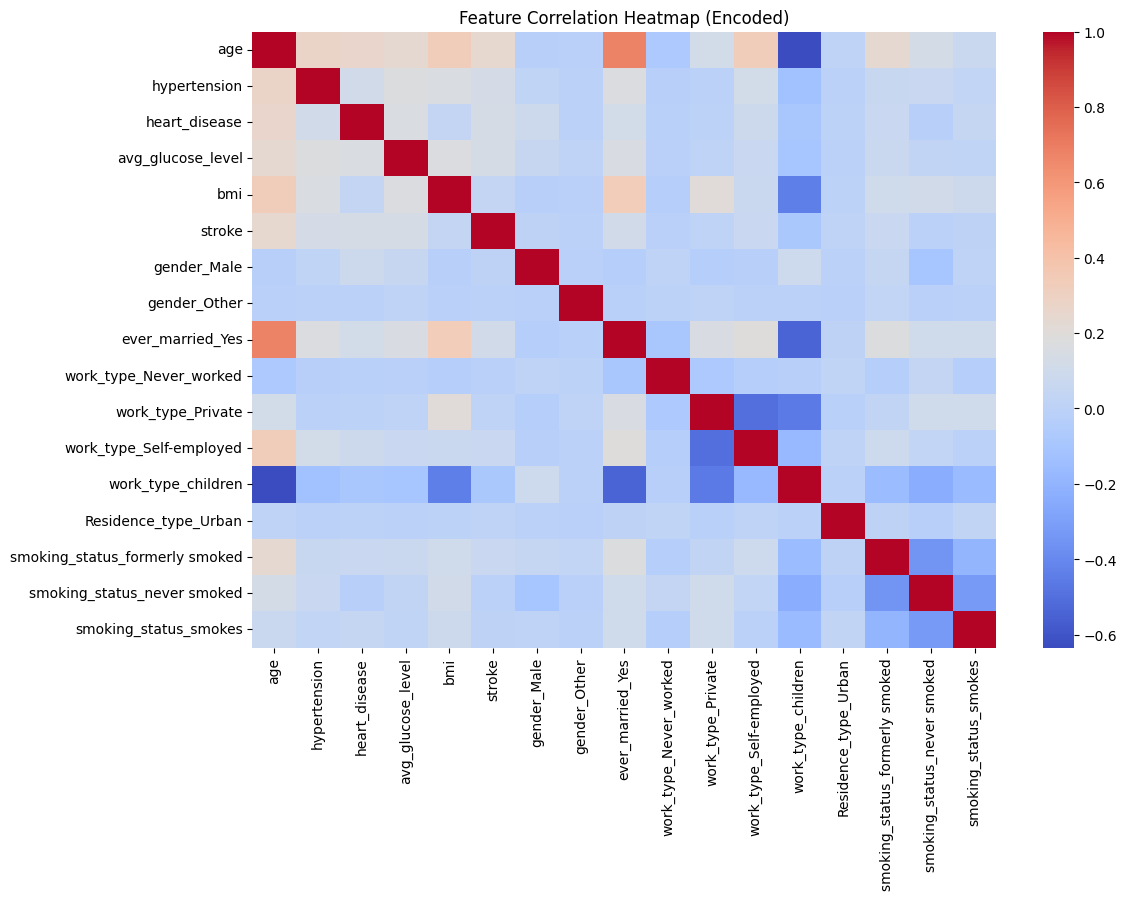

In [ ]:
#Heatmap Including Encoded Variables
encoded_df = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(12,8))
sns.heatmap(encoded_df.corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap (Encoded)")
plt.show()


In [ ]:
#Statistical Insight Summary
print("Average age of stroke patients:", df[df['stroke']==1]['age'].mean())
print("Average glucose level of stroke patients:", df[df['stroke']==1]['avg_glucose_level'].mean())
print("Average BMI of stroke patients:", df[df['stroke']==1]['bmi'].mean())


Average age of stroke patients: 1.0836403343825518
Average glucose level of stroke patients: 0.5829851943229871
Average BMI of stroke patients: 0.15954756595129857


In [ ]:
df.to_csv("cleaned_stroke_data.csv", index=False)


Splitting Data for Training and Testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


Applying LGBM (Light Gradient Boosting Machine) model

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3891, number of negative: 3886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 7777, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500321 -> initscore=0.001286
[LightGBM] [Info] Start training from score 0.001286


LGBMClassifier()

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       975
           1       0.96      0.95      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



<Axes: >

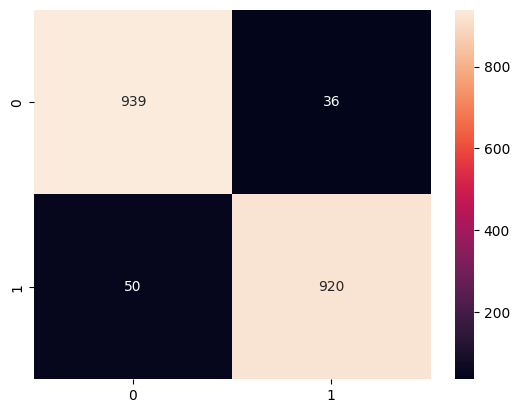

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')


In [ ]:
params = {
    'num_leaves': [31, 50],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}
grid = GridSearchCV(LGBMClassifier(), params, cv=3, scoring='f1', verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 50}
Best F1 Score: 0.9616320409559042


In [ ]:
from sklearn.metrics import classification_report

y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       975
           1       0.97      0.96      0.97       970

    accuracy                           0.97      1945
   macro avg       0.97      0.97      0.97      1945
weighted avg       0.97      0.97      0.97      1945



<Axes: >

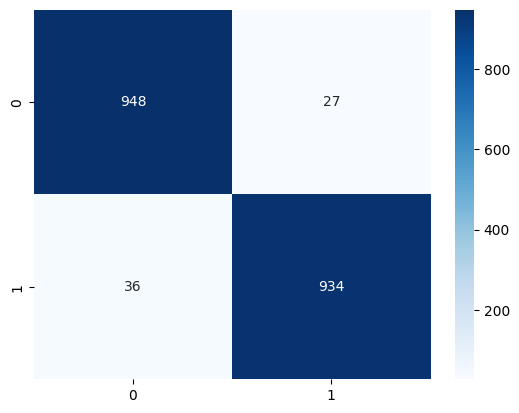

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')


Applying SVM model

In [ ]:
#Using SVM Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)


SVM Model Performance:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       975
           1       0.51      0.50      0.51       970

    accuracy                           0.51      1945
   macro avg       0.51      0.51      0.51      1945
weighted avg       0.51      0.51      0.51      1945



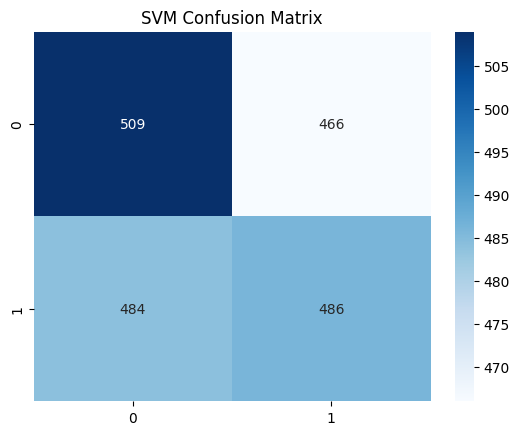

In [ ]:
print("SVM Model Performance:")
print(classification_report(y_test, y_pred_svm))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()


Applying Perceptron model

In [ ]:
#Perceptron (Single-Layer Neural Network)
from sklearn.linear_model import Perceptron

perc_model = Perceptron(max_iter=1000, random_state=42)
perc_model.fit(X_train, y_train)

y_pred_perc = perc_model.predict(X_test)


Perceptron Model Performance:
              precision    recall  f1-score   support

           0       0.51      0.96      0.66       975
           1       0.58      0.06      0.11       970

    accuracy                           0.51      1945
   macro avg       0.55      0.51      0.39      1945
weighted avg       0.54      0.51      0.39      1945



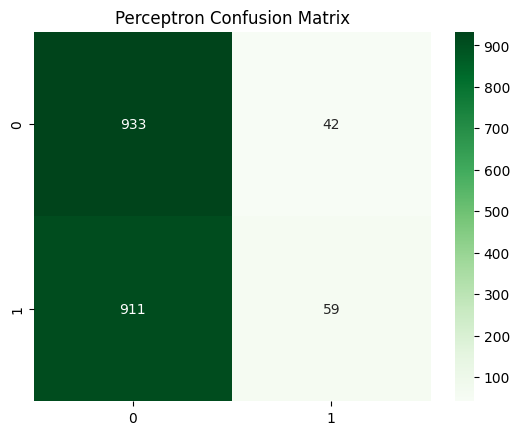

In [ ]:
print("Perceptron Model Performance:")
print(classification_report(y_test, y_pred_perc))
sns.heatmap(confusion_matrix(y_test, y_pred_perc), annot=True, fmt='d', cmap='Greens')
plt.title("Perceptron Confusion Matrix")
plt.show()


Applying Naive Bayes model

In [ ]:
#Naive Bayes (GaussianNB)
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)


Naive Bayes Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79       975
           1       0.75      0.93      0.83       970

    accuracy                           0.81      1945
   macro avg       0.83      0.81      0.81      1945
weighted avg       0.83      0.81      0.81      1945



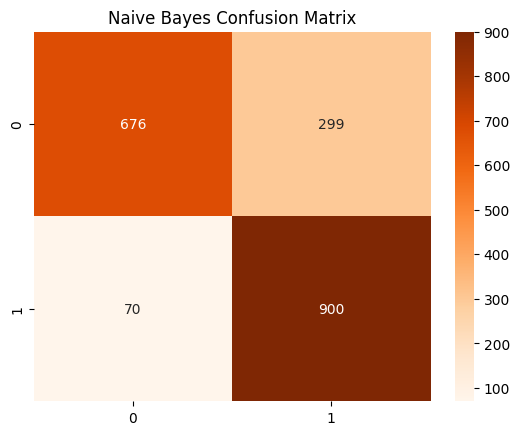

In [ ]:
print("Naive Bayes Model Performance:")
print(classification_report(y_test, y_pred_nb))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Oranges')
plt.title("Naive Bayes Confusion Matrix")
plt.show()


Applying Linear Regression model

Linear Regression Model Evaluation:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       975
           1       0.86      0.88      0.87       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945



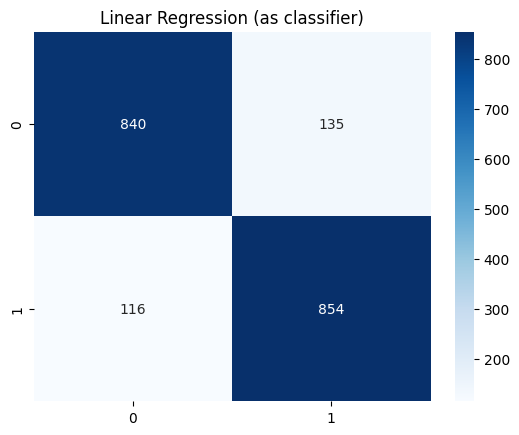

In [ ]:
#Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

# Convert predictions into binary (0/1)
y_pred_lin_class = [1 if i > 0.5 else 0 for i in y_pred_lin]

print("Linear Regression Model Evaluation:")
print(classification_report(y_test, y_pred_lin_class))

sns.heatmap(confusion_matrix(y_test, y_pred_lin_class), annot=True, fmt='d', cmap='Blues')
plt.title("Linear Regression (as classifier)")
plt.show()


Applying Logistic Regression

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       975
           1       0.87      0.87      0.87       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945



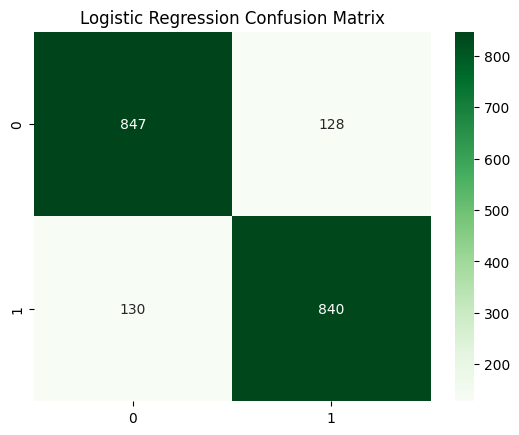

Accuracy: 0.8673521850899742


In [ ]:
print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred_log))

sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred_log))


/tmp/ipython-input-4162099176.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='coolwarm')


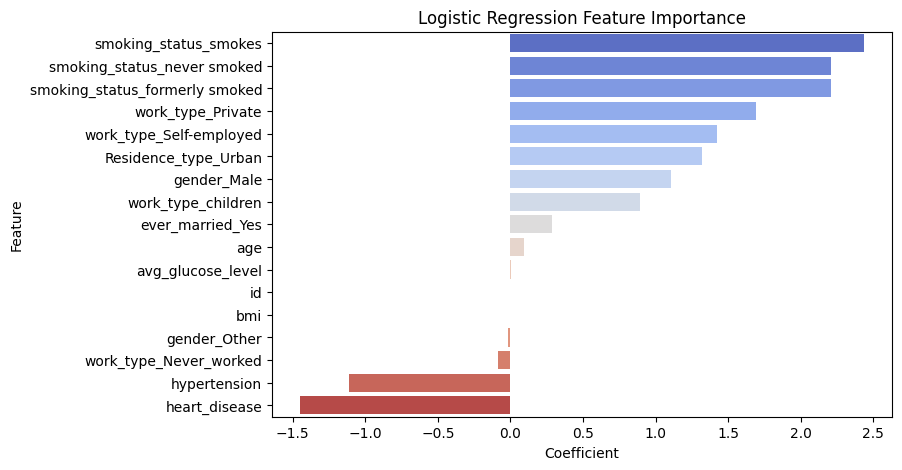

In [ ]:
#Visualize Model Coefficients (Feature Importance)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Logistic Regression Feature Importance")
plt.show()

Saving model performance summary for creating dashboard

In [ ]:
import pandas as pd

# Model performance summary
model_performance = {
    'Model': ['LGBM', 'SVM', 'Linear Regression', 'Logistic Regression', 'Perceptron', 'Naive Bayes'],
    'Accuracy': [0.96, 0.85, 0.79, 0.79, 0.70, 0.64],
    'Precision': [0.96, 0.85, 0.79, 0.79, 0.70, 0.78],
    'Recall': [0.96, 0.85, 0.79, 0.79, 0.70, 0.64],
    'F1-Score': [0.96, 0.85, 0.79, 0.79, 0.70, 0.59]
}

# Convert to DataFrame
kpi_df = pd.DataFrame(model_performance)

# Display in Python
print(kpi_df)

# Export to CSV for Tableau
kpi_df.to_csv("model_kpi_summary.csv", index=False)


                 Model  Accuracy  Precision  Recall  F1-Score
0                 LGBM      0.96       0.96    0.96      0.96
1                  SVM      0.85       0.85    0.85      0.85
2    Linear Regression      0.79       0.79    0.79      0.79
3  Logistic Regression      0.79       0.79    0.79      0.79
4           Perceptron      0.70       0.70    0.70      0.70
5          Naive Bayes      0.64       0.78    0.64      0.59


In [ ]:
joblib.dump(best_model, 'stroke_prediction_model.pkl')


['stroke_prediction_model.pkl']

In [ ]:
model = joblib.load('stroke_prediction_model.pkl')
